# 30mer Regression analysis

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
from itertools import cycle
import pickle, sys
from yellowbrick.regressor import ResidualsPlot

import sklearn.manifold
from sklearn.metrics import roc_curve, auc, r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import label_binarize, PolynomialFeatures
from sklearn.svm import LinearSVR, SVR
from sklearn.feature_selection import SelectFromModel, RFECV, VarianceThreshold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.kernel_ridge import KernelRidge

from math import log10, pow, log,sqrt
from statistics import mean
import scipy.stats as stats

In [23]:
#Load data
rownames = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/ML_REG_input30mer_7514.csv", "rb"),delimiter=',', dtype='str')[0,:]
names = np.asarray([_ for _ in rownames])
df = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/ML_REG_input30mer_7514.csv", "rb"),delimiter=',', usecols=range(1,rownames.shape[0]), dtype='float', skiprows=1)
sgRNA_seq = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/ML_REG_input30mer_7514.csv", "rb"),delimiter=',', usecols=0, dtype='str', skiprows=1)

#sort by sequence (not by activity/efficiency which is the response variable)
indx = sgRNA_seq.argsort()
df = df[indx,:]

#Standard scale non binary features
sc = StandardScaler()
df[:,1:26] = sc.fit_transform(df[:,1:26])

#Save standardized dataset
pd.DataFrame(np.column_stack((sgRNA_seq, df)), columns=names).to_csv("/home/pierre/Desktop/Position_Matrix/ML_REG_input30mer_7514-scaled.csv",index=False)

#Number of cpus to use for multithreading
n_cpu = 5

## RFECV

In [5]:
#Recursive Feature Elimination with Cross-Validation to remove the irrelevant features

modelnames = [
    "Linear Regression",
    "Linear SVR",
    "l2 Linear Regression",
    "Gradient-Boosted Decision Tree",
    "Random Forest"
]

model = [
    LinearRegression(n_jobs=n_cpu),
    LinearSVR(random_state=0),
    Ridge(random_state=0),
    GradientBoostingRegressor(random_state=0),
    RandomForestRegressor(random_state=0)
]

rfecv = dict()
models=dict()
datasets=dict()
supports = dict()
i=0
for name, clf in zip(modelnames, model):    
    model = RFECV(estimator=clf, 
                    cv=KFold(n_splits=10, random_state=0), 
                    scoring='r2', n_jobs=n_cpu)
    rfecv[i] = model
    model.fit(df[:,1:], df[:,0])

    X_new = model.transform(df[:,1:])
    sup = model.get_support(True)
    
    #Insert Column names
    X_new = pd.DataFrame(X_new, columns=names[2:][sup])

    print(X_new.shape)
    
    datasets[i] = X_new
    supports[i] = sup
    
    i+=1

(7514, 26)
(7514, 103)
(7514, 238)


KeyboardInterrupt: 

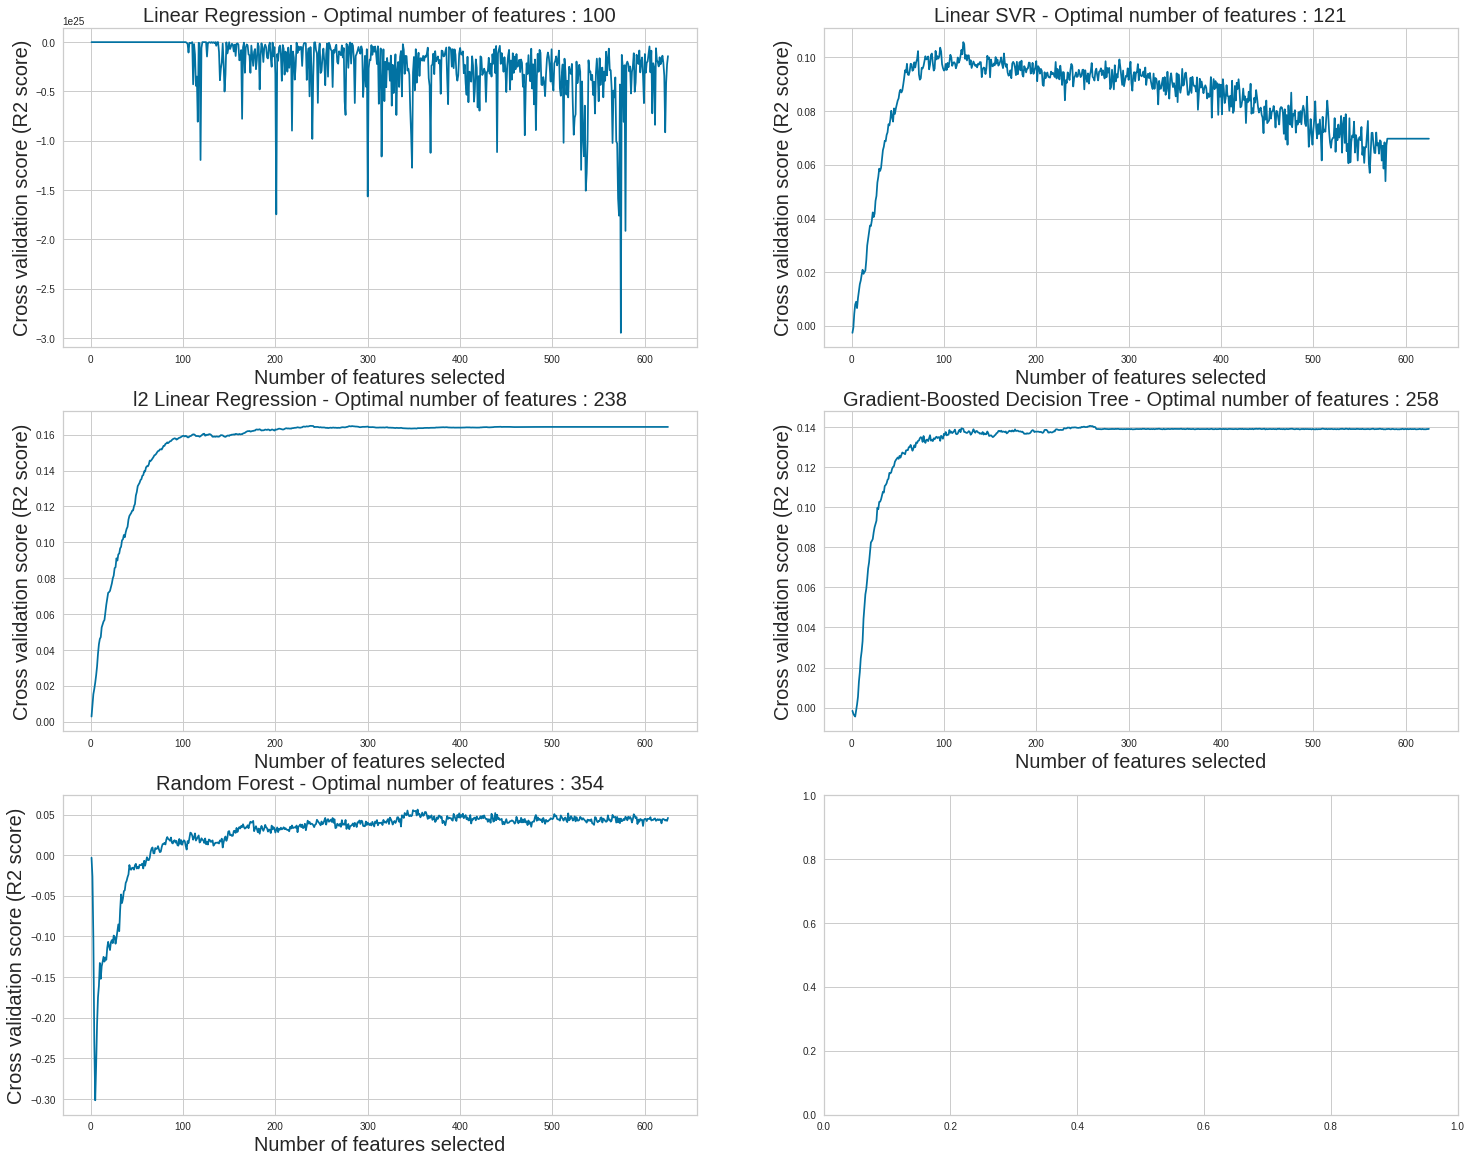

In [3]:
# RFECV to plot
modelnames = [
    "Linear Regression",
    "Linear SVR",
    "l2 Linear Regression",
    "Gradient-Boosted Decision Tree",
    "Random Forest"
]
n_groups = 5

# create plot
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(25,20))
plt.figure()

index = np.arange(n_groups)

for ax, i in zip(axes.flatten(),range(n_groups)):
    rfecv_model = rfecv[i]
    X_newL1 = datasets[i]

    ax.set_xlabel("Number of features selected", fontsize=20)
    ax.set_ylabel("Cross validation score (R2 score)", fontsize=20)
    ax.set_title("%s - Optimal number of features : %d" % (modelnames[i], X_newL1.shape[1]), fontsize=20)
    ax.plot(range(1, len(rfecv_model.grid_scores_) + 1), rfecv_model.grid_scores_)
    
plt.show()

In [ ]:
#Save the rfecv and it's associated dataset and relevant features

data = {
    'rfecv': rfecv,
    'datasets': datasets,
    'supports': supports
}

pickle_out = open("30mer_RFECV.pickle","wb")
pickle.dump(data, pickle_out)
pickle_out.close()

In [3]:
# # Uncomment to load the rfecv and datasets
# pickle_in = open("30mer_RFECV.pickle","rb")
# p_load = pickle.load(pickle_in)

# rfecv = p_load['rfecv']
# datasets = p_load['datasets']
# supports = p_load['supports']

## Hyperparameter Optimization & Performance Evaluation

In [ ]:
# find the best hyperparameters for each model and evaluate its performance on the training set

models = [LinearRegression(),
          LinearSVR(),
          Ridge(),
          GradientBoostingRegressor(),
          RandomForestRegressor()
        ]

# set up params

tuned_parameters = [{},
                    {'loss': ['epsilon_insensitive','squared_epsilon_insensitive'],
                     'epsilon': [0,0.001,0.01,0.1,1],
                     'C': [0.001,0.01,0.1,1,10,100,1000]},
                    {'alpha': np.logspace(log10(10e-5),log10(1.5e5),100)},
                    {'n_estimators':[50,100,150,200],
                    'max_depth':[2,4,6,8,10],
                    'min_samples_split':[2,4],
                    'min_samples_leaf':[1,2],
                    'max_features':['auto','sqrt','log2']},
                    {'n_estimators':[50,100,150,200],
                     'max_depth':[2,4,6,8,10],
                     'min_samples_split':[2,4],
                     'min_samples_leaf':[1,2],
                     'max_features':['auto','sqrt','log2']}
                   ]
grid = dict()

for i in datasets :
    print(datasets[i].shape)
    grid[i] = dict()
    for j in range(len(models)):
        
        print(str(models[j]))
        print(str(tuned_parameters[j]))
        print()
        
        #Inner CV for parameter Optimization
        grid[i][j] = GridSearchCV(models[j], 
                                  tuned_parameters[j], 
                                  cv=KFold(n_splits=10, shuffle=True, random_state=i+j), 
                                  scoring='r2',n_jobs=n_cpu).fit(datasets[i], df[:,0])

In [7]:
r2 = dict()
r2_adj = dict()
RMSE = dict()

for i in grid :
    print(datasets[i].shape)
    n =(datasets[i].shape[0])
    k =(datasets[i].shape[1])
    r2[i] = dict()
    r2_adj[i] = dict()
    RMSE[i] = dict()
    for j in range(len(grid[i])):
        print(str(grid[i][j]))
        
        scoreR2 = np.mean(cross_val_score(grid[i][j].best_estimator_, datasets[i], df[:,0], cv=KFold(n_splits=10, shuffle=True, random_state=i+j), scoring='r2', n_jobs=n_cpu))
        print('r2 = ',scoreR2)
        
        scoreR2_adj =1-(1-scoreR2)*(n-1)/(n-(k+1))
        print('r2_adj = ',scoreR2_adj)
        
        scoreRMSE = np.mean(cross_val_score(grid[i][j].best_estimator_, datasets[i], df[:,0], cv=KFold(n_splits=10, shuffle=True, random_state=i+j), scoring='neg_mean_squared_error', n_jobs=n_cpu))
        print('RMSE = ',sqrt(abs(scoreRMSE)))
        
        r2[i][j] = scoreR2
        r2_adj[i][j] = scoreR2_adj
        RMSE[i][j] = sqrt(abs(scoreRMSE))
        
        print('_____________')

(7514, 100)
GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
       error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=2, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)
r2 =  0.09253889247084865
r2_adj =  0.08029740983859257
RMSE =  0.274933463236909
_____________
GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'], 'epsilon': [0, 0.001, 0.01, 0.1, 1], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True

r2 =  0.17017099501139604
r2_adj =  0.1565874845130707
RMSE =  0.2628609772279301
_____________
GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_estimators': [50, 100, 150, 200], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 2], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)
r2 =  0.11655142768604207
r2_adj =  0.1020902159368553
RMSE =  0.2712744208

r2 =  0.1799535355228228
r2_adj =  0.1055445575468884
RMSE =  0.2613265604849866
_____________
GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': array([1.00000e-04, 1.23791e-04, ..., 1.21172e+05, 1.50000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)
r2 =  0.18130518428108902
r2_adj =  0.10701885155398105
RMSE =  0.2611030295689822
_____________
GridSearchCV(cv=KFold(n_splits=10, random_state=8, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
   

r2 =  0.1881272368004764
r2_adj =  0.15925567609675795
RMSE =  0.2600196614056854
_____________
GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
       error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': array([1.00000e-04, 1.23791e-04, ..., 1.21172e+05, 1.50000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)
r2 =  0.18491062607365993
r2_adj =  0.15592467728344694
RMSE =  0.260526987131927
_____________
GridSearchCV(cv=KFold(n_splits=10, random_state=8, shuffle=True),
       error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      rando

r2 =  0.12345886604702465
r2_adj =  0.08011544358308365
RMSE =  0.2702355541145736
_____________


# Save the Models and the R2, R2adj, RMSE

In [ ]:
data = {
    'grid': grid,
    'r2': r2,
    'r2_adj': r2_adj,
    'RMSE': RMSE
}

pickle_out = open("30mer_GRID&Perf.pickle","wb")
pickle.dump(data, pickle_out)
pickle_out.close()

In [4]:
# #Uncomment to load performance
# pickle_in = open("30mer_GRID&Perf.pickle","rb")
# p_load = pickle.load(pickle_in)

# grid = p_load['grid']
# r2 = p_load['r2']
# r2_adj = p_load['r2_adj']
# RMSE = p_load['RMSE']

# Plot the performance comparison on the training set

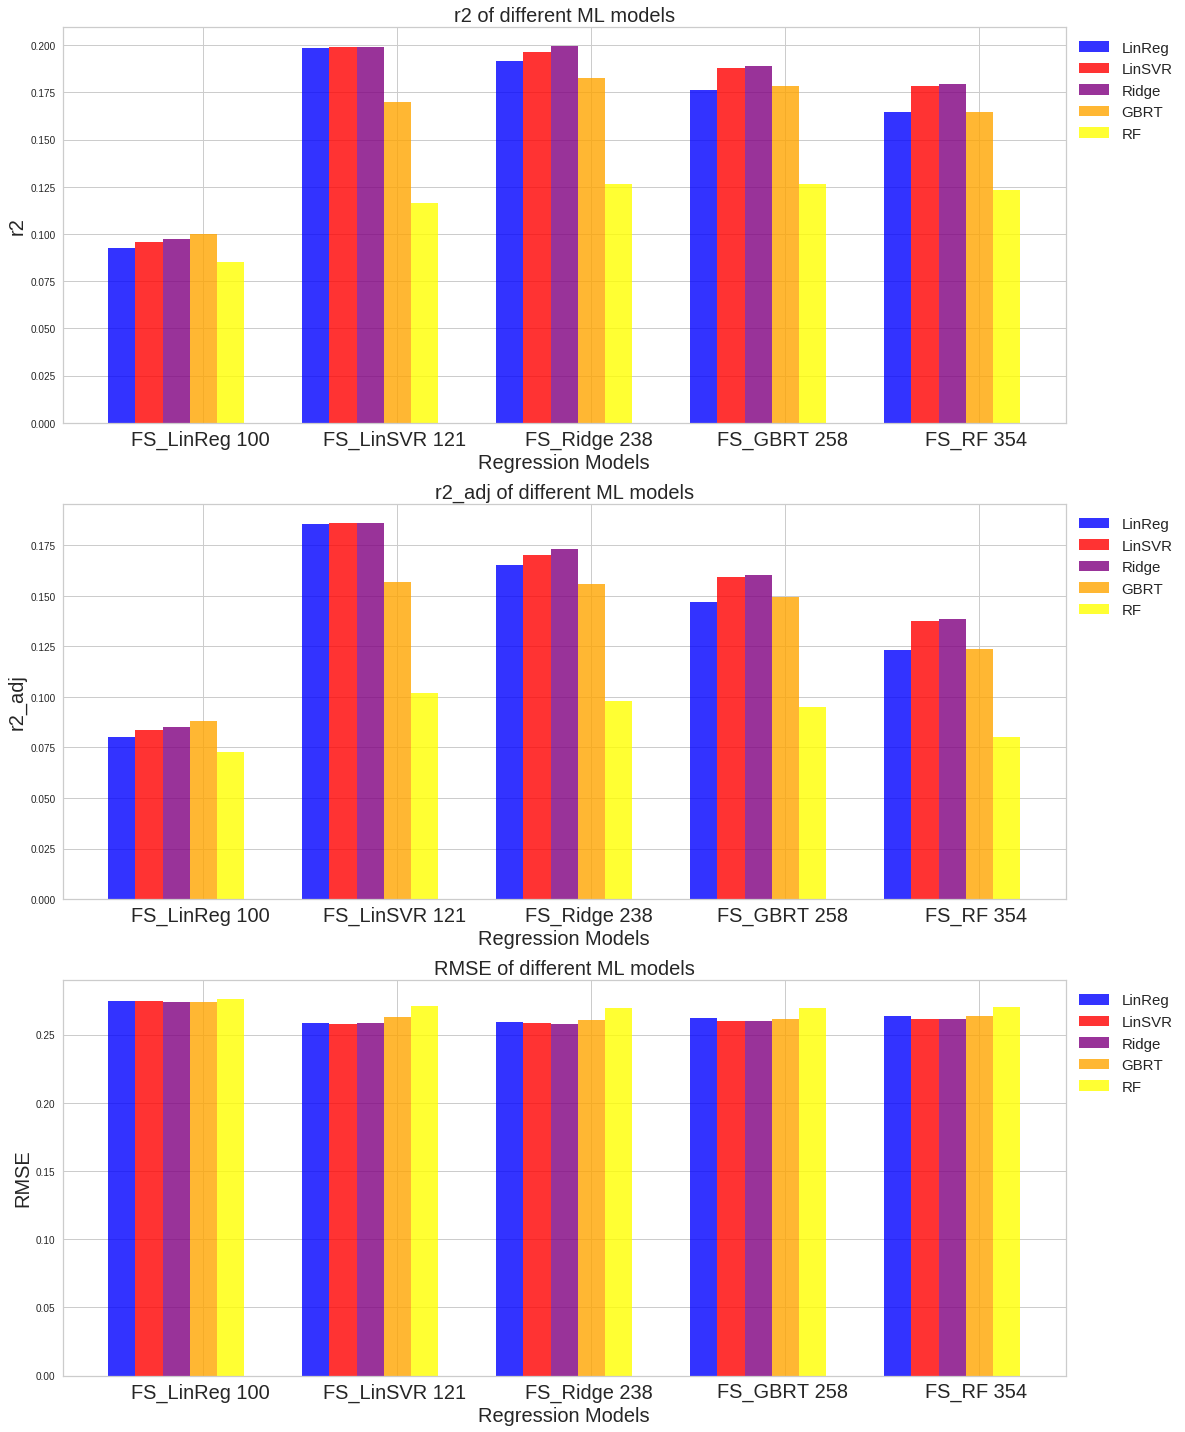

In [5]:
n_groups = 5
metrics = {'r2':r2, 'r2_adj':r2_adj, 'RMSE':RMSE}

# create plot
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(15,20))

index = np.arange(n_groups)
bar_width = 0.14
opacity = 0.8

i=0
for ax, v in zip(axes.flatten(),metrics.keys()):
    FS_LinReg = list()
    FS_LinSVR = list()
    FS_Ridge = list()
    FS_GBRT = list()
    FS_RF = list()
    for i in range(len(metrics[v])):
        FS_LinReg.append(metrics[v][i][0])
        FS_LinSVR.append(metrics[v][i][1])
        FS_Ridge.append(metrics[v][i][2])
        FS_GBRT.append(metrics[v][i][3])
        FS_RF.append(metrics[v][i][4])
    FS_LinReg = tuple(FS_LinReg)
    FS_LinSVR = tuple(FS_LinSVR)
    FS_Ridge = tuple(FS_Ridge)
    FS_GBRT = tuple(FS_GBRT)
    FS_RF = tuple(FS_RF)

    rects1 = ax.bar(index, FS_LinReg, bar_width, align = 'center',
                     alpha=opacity,
                     color='blue',
                     label='LinReg')

    rects2 = ax.bar(index + bar_width, FS_LinSVR, bar_width, align = 'center',
                     alpha=opacity,
                     color='red',
                     label='LinSVR')

    rects5 = ax.bar(index + bar_width*2, FS_Ridge, bar_width, align = 'center',
                     alpha=opacity,
                     color='purple',
                     label='Ridge')

    rects6 = ax.bar(index + bar_width*3, FS_GBRT, bar_width, align = 'center',
                     alpha=opacity,
                     color='orange',
                     label='GBRT')

    rects7 = ax.bar(index + bar_width*4, FS_RF, bar_width, align = 'center',
                     alpha=opacity,
                     color='yellow',
                     label='RF')

    ax.set_xlabel('Regression Models',fontsize=20)
    ax.set_ylabel(v,fontsize=20)
    ax.set_title('%s of different ML models' % v,fontsize=20)
    ax.set_xticks(index + bar_width*3)
    ax.set_xticklabels(['FS_LinReg %i ' % datasets[0].shape[1], 
                        'FS_LinSVR %i ' % datasets[1].shape[1], 
                        'FS_Ridge %i ' % datasets[2].shape[1], 
                        'FS_GBRT %i ' % datasets[3].shape[1],
                        'FS_RF %i ' % datasets[4].shape[1]], fontsize=20)
    ax.legend(fontsize=15,loc='upper right', bbox_to_anchor=(1.12, 1), ncol=1)
    i+=1

plt.tight_layout()
plt.show()

## Save Best Model

In [78]:
data = {
    'model': grid[1][1].best_estimator_,
    'df_indexes': supports[1]
}

pickle_out = open("30mer_121FS_LinSVR_REGmodel.pickle","wb")
pickle.dump(data, pickle_out)
pickle_out.close()

In [6]:
# #Uncomment ot lead the best model
# pickle_in = open("30mer_121FS_LinSVR_REGmodel.pickle","rb")
# p_load = pickle.load(pickle_in)
# Model = p_load['model']
# idx = p_load['df_indexes']

# Residual plot Analysis

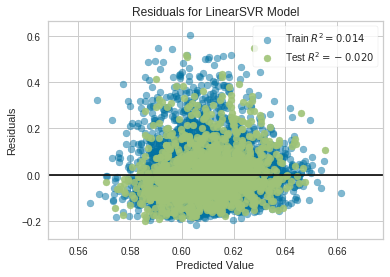

In [24]:
# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(datasets[1], df[:,0], test_size=0.2)

model = Model
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof() 

## feature importance

In [10]:
df_importance = pd.DataFrame(grid[1][3].best_estimator_.feature_importances_, datasets[1].columns)
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(df_importance)

               0
A0      0.011014
A1      0.010506
A2      0.009186
A6      0.006870
A10     0.017224
A12     0.010163
A18     0.008682
A20     0.007697
C3      0.014712
C4      0.010360
C13     0.010923
C14     0.012774
C23     0.010341
G6      0.012401
G7      0.012442
G8      0.015918
G10     0.010676
G11     0.014066
G12     0.016080
G13     0.016300
G19     0.011535
G21     0.000000
G22     0.000000
G23     0.013569
G25     0.009103
T4      0.009575
T11     0.012400
T12     0.011476
T23     0.006747
AA-2    0.004700
AA5     0.005517
AA7     0.008755
AA8     0.006453
AA14    0.005516
AA17    0.008122
AC-1    0.004406
AC0     0.006056
AC13    0.006823
AC16    0.010039
AC19    0.009131
AC24    0.006127
AG-1    0.006911
AG5     0.007257
AG9     0.005242
AG11    0.011224
AG23    0.006231
AT-3    0.007292
AT14    0.007711
AT15    0.005455
CA5     0.010732
CA6     0.008438
CA8     0.005054
CA10    0.004352
CA11    0.007470
CA15    0.008155
CA16    0.007911
CA18    0.007068
CC1     0.0091

In [13]:
pos_indep_order1 = 0
print(pos_indep_order1)
pos_dep_order1 = sum(df_importance.iloc[0:29][0])
print(pos_dep_order1)

pos_indep_order2 = 0
print(pos_indep_order2)
pos_dep_order2 = sum(df_importance.iloc[29:118][0])
print(pos_dep_order2)

PAM_bounds = sum(df_importance.iloc[118:][0])
print(PAM_bounds)

0
0.3127385257406146
0
0.6677539967532048
0.019507477506180617


1.0


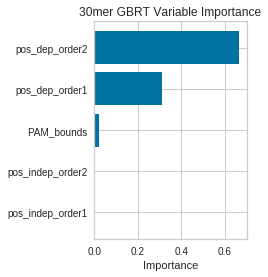

In [19]:
print(sum((pos_indep_order1,pos_indep_order2,PAM_bounds,pos_dep_order1,pos_dep_order2)))

pos = np.arange(5) + .5
plt.subplot(1, 2, 2)
plt.barh(pos,(pos_indep_order1,pos_indep_order2,PAM_bounds,pos_dep_order1,pos_dep_order2), align='center')
plt.yticks(pos, ('pos_indep_order1','pos_indep_order2','PAM_bounds','pos_dep_order1','pos_dep_order2'))
plt.xlabel('Importance')
plt.title('30mer GBRT Variable Importance')
plt.show()

## Guide efficiency performance

### Training set

In [15]:
scoredf = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/Analysis-30mer_sgRNA_7514predictions.csv", "rb"), delimiter=',', usecols=(2,3), dtype='float', skiprows=1)
indx = scoredf[:,1].argsort()
scoredf = scoredf[indx,:]


dic_scores = dict()
k=0
for i in np.arange(0,1,0.1):
    dic_scores[k]= scoredf[np.where((scoredf[:,1]>=i) & (scoredf[:,1]<i+0.1)),]
    k+=1
#print(dic_scores)


npRed = list()
npOrange = list()
npYellow = list()
npGreen = list()
for i in dic_scores:
    npRed.append(len(np.where((dic_scores[i][0][:,0]>=0) & (dic_scores[i][0][:,0]<0.25))[0])/len(dic_scores[i][0][:,0])*100)
    npOrange.append(len(np.where((dic_scores[i][0][:,0]>=0.25) & (dic_scores[i][0][:,0]<0.5))[0])/len(dic_scores[i][0][:,0])*100)
    npYellow.append(len(np.where((dic_scores[i][0][:,0]>=0.5) & (dic_scores[i][0][:,0]<0.75))[0])/len(dic_scores[i][0][:,0])*100)
    npGreen.append(len(np.where((dic_scores[i][0][:,0]>=0.75) & (dic_scores[i][0][:,0]<1.0))[0])/len(dic_scores[i][0][:,0])*100)

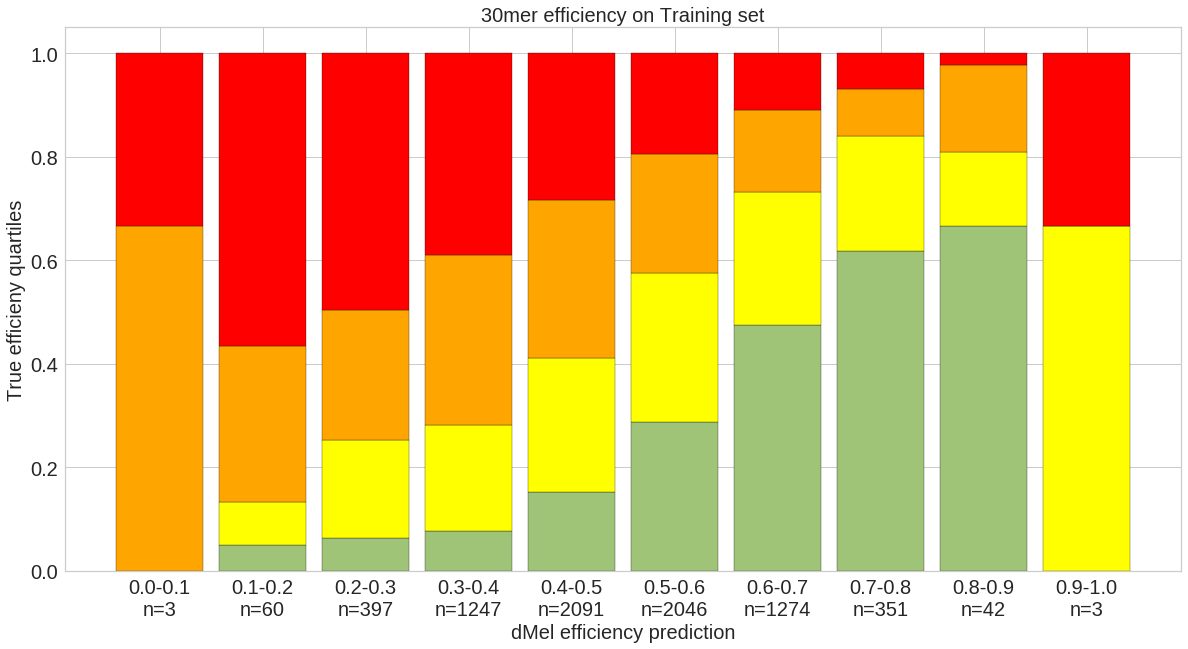

In [16]:
# Data
r = [0,1,2,3,4,5,6,7,8,9]
raw_data = {'greenBars': npGreen, 
            'yellowBars': npYellow,
            'orangeBars': npOrange,
            'redBars': npRed
           }
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k+l for i,j,k,l in zip(df['greenBars'], df['yellowBars'], df['orangeBars'], df['redBars'])]
greenBars = [i / j for i,j in zip(df['greenBars'], totals)]
yellowBars = [i / j for i,j in zip(df['yellowBars'], totals)]
orangeBars = [i / j for i,j in zip(df['orangeBars'], totals)]
redBars = [i / j for i,j in zip(df['redBars'], totals)]
 
# plot
plt.figure(figsize=(20,10))
plt.rc('axes', titlesize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
barWidth = 0.85
names = ('0.0-0.1\nn=%s' % len(dic_scores[0][0][:,0]),
         '0.1-0.2\nn=%s' % len(dic_scores[1][0][:,0]),
         '0.2-0.3\nn=%s' % len(dic_scores[2][0][:,0]),
         '0.3-0.4\nn=%s' % len(dic_scores[3][0][:,0]),
         '0.4-0.5\nn=%s' % len(dic_scores[4][0][:,0]),
         '0.5-0.6\nn=%s' % len(dic_scores[5][0][:,0]),
         '0.6-0.7\nn=%s' % len(dic_scores[6][0][:,0]),
         '0.7-0.8\nn=%s' % len(dic_scores[7][0][:,0]),
         '0.8-0.9\nn=%s' % len(dic_scores[8][0][:,0]),
         '0.9-1.0\nn=%s' % len(dic_scores[9][0][:,0]))
# Create green Bars
plt.bar(r, greenBars, color='g', edgecolor='black', width=barWidth)
# Create yellow Bars
plt.bar(r, yellowBars, bottom=greenBars, color='yellow', edgecolor='black', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=[i+j for i,j in zip(greenBars, yellowBars)], color='orange', edgecolor='black', width=barWidth)
# Create red Bars
plt.bar(r, redBars, bottom=[i+j+k for i,j,k in zip(greenBars, yellowBars,orangeBars)], color='red', edgecolor='black', width=barWidth)


# Custom x axis
plt.xticks(r, names)
plt.title("30mer efficiency on Training set")
plt.xlabel("dMel efficiency prediction", fontsize=20)
plt.ylabel("True efficieny quartiles", fontsize=20)
 
# Show graphic
plt.show()

### Testing set

In [17]:
scoredf = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/Analysis-Test_Set_Droso.csv", "rb"), delimiter=',', usecols=(4,7), dtype='float', skiprows=1)
indx = scoredf[:,1].argsort()
scoredf = scoredf[indx,:]


dic_scores = dict()
k=0
for i in np.arange(0,1,0.1):
    dic_scores[k]= scoredf[np.where((scoredf[:,1]>=i) & (scoredf[:,1]<i+0.1)),]
    k+=1
#print(dic_scores)


npRed = list()
npOrange = list()
npYellow = list()
npGreen = list()
for i in dic_scores:
    npRed.append(len(np.where((dic_scores[i][0][:,0]>=0) & (dic_scores[i][0][:,0]<0.25))[0])/len(dic_scores[i][0][:,0])*100)
    npOrange.append(len(np.where((dic_scores[i][0][:,0]>=0.25) & (dic_scores[i][0][:,0]<0.5))[0])/len(dic_scores[i][0][:,0])*100)
    npYellow.append(len(np.where((dic_scores[i][0][:,0]>=0.5) & (dic_scores[i][0][:,0]<0.75))[0])/len(dic_scores[i][0][:,0])*100)
    npGreen.append(len(np.where((dic_scores[i][0][:,0]>=0.75) & (dic_scores[i][0][:,0]<1.0))[0])/len(dic_scores[i][0][:,0])*100)

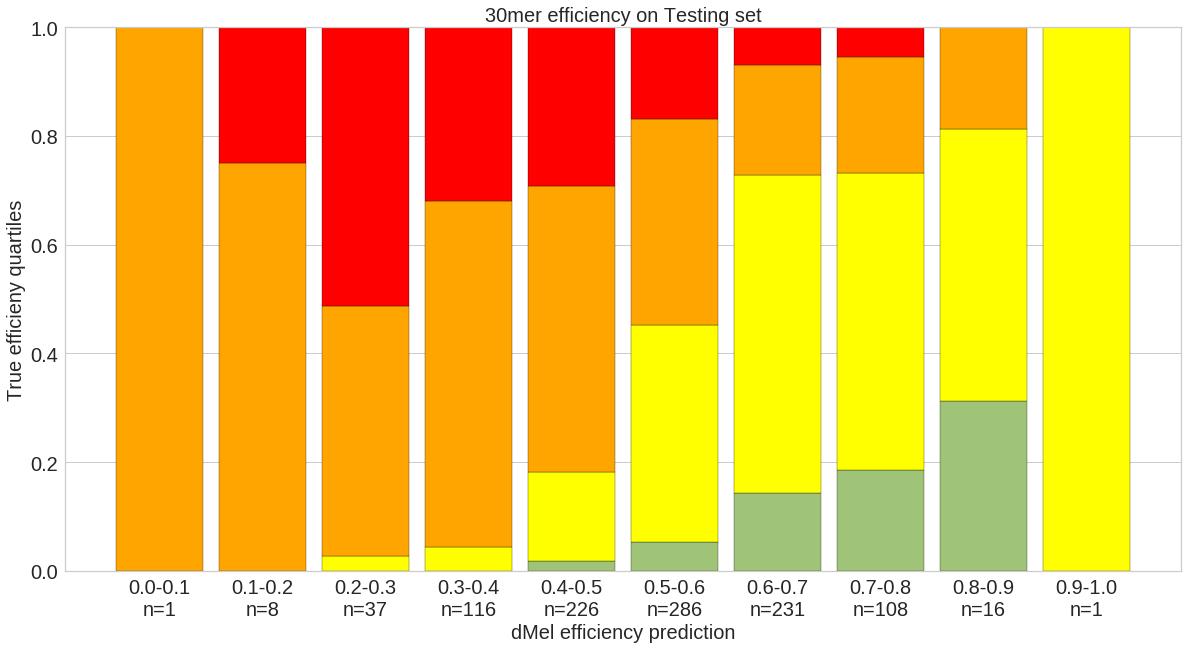

In [18]:
# Data
r = [0,1,2,3,4,5,6,7,8,9]
raw_data = {'greenBars': npGreen, 
            'yellowBars': npYellow,
            'orangeBars': npOrange,
            'redBars': npRed
           }
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k+l for i,j,k,l in zip(df['greenBars'], df['yellowBars'], df['orangeBars'], df['redBars'])]
greenBars = [i / j for i,j in zip(df['greenBars'], totals)]
yellowBars = [i / j for i,j in zip(df['yellowBars'], totals)]
orangeBars = [i / j for i,j in zip(df['orangeBars'], totals)]
redBars = [i / j for i,j in zip(df['redBars'], totals)]
 
# plot
plt.figure(figsize=(20,10))
plt.rc('axes', titlesize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
barWidth = 0.85
names = ('0.0-0.1\nn=%s' % len(dic_scores[0][0][:,0]),
         '0.1-0.2\nn=%s' % len(dic_scores[1][0][:,0]),
         '0.2-0.3\nn=%s' % len(dic_scores[2][0][:,0]),
         '0.3-0.4\nn=%s' % len(dic_scores[3][0][:,0]),
         '0.4-0.5\nn=%s' % len(dic_scores[4][0][:,0]),
         '0.5-0.6\nn=%s' % len(dic_scores[5][0][:,0]),
         '0.6-0.7\nn=%s' % len(dic_scores[6][0][:,0]),
         '0.7-0.8\nn=%s' % len(dic_scores[7][0][:,0]),
         '0.8-0.9\nn=%s' % len(dic_scores[8][0][:,0]),
         '0.9-1.0\nn=%s' % len(dic_scores[9][0][:,0]))
# Create green Bars
plt.bar(r, greenBars, color='g', edgecolor='black', width=barWidth)
# Create yellow Bars
plt.bar(r, yellowBars, bottom=greenBars, color='yellow', edgecolor='black', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=[i+j for i,j in zip(greenBars, yellowBars)], color='orange', edgecolor='black', width=barWidth)
# Create red Bars
plt.bar(r, redBars, bottom=[i+j+k for i,j,k in zip(greenBars, yellowBars,orangeBars)], color='red', edgecolor='black', width=barWidth)


# Custom x axis
plt.xticks(r, names)
plt.title("30mer efficiency on Testing set")
plt.xlabel("dMel efficiency prediction", fontsize=20)
plt.ylabel("True efficieny quartiles", fontsize=20)
 
# Show graphic
plt.show()